# Machine Learning Task 1
## Silvana Belegu
### Task Description
Run KNN sequentially and in parallel by making use of Ray. Perform benchmark studies in both of them and visualize the results. 

In [3]:
import multiprocessing as mp

In [4]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  128


### Running the code sequentially 

In [87]:
from KNNClassifier import KNNClassifier
import numpy as np
import time, timeit
import cProfile, pstats
from tqdm.notebook import tqdm

In [88]:
rows = 100000
cols = 500
np.random.seed(699)
X_train = np.random.rand(rows*cols).reshape((rows,cols))
y_train = np.random.randint(2, size=rows)
print(f'X_train shape {X_train.shape} - y_train shape {y_train.shape}')

X_train shape (100000, 500) - y_train shape (100000,)


In [7]:
knn = KNNClassifier(k=2)
knn.fit(X_train, y_train)

In [93]:
test_size = 1000
X_test = np.random.randint(rows, size=test_size)

Run the process using cProfile to get more information on which of the functions takes more time to be run or is called more often. 

In [21]:
cProfile.run('knn.predict(X_train[X_test])', 'profile_results.prof')

In [25]:
stats = pstats.Stats('profile_results.prof')
stats.sort_stats('cumulative').print_stats(30)

Sun Nov 24 21:53:20 2024    profile_results.prof

         1000017006 function calls in 911.125 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  911.125  911.125 {built-in method builtins.exec}
        1    0.001    0.001  911.125  911.125 <string>:1(<module>)
        1    0.000    0.000  911.124  911.124 /mnt/lscratch/users/sbelegu/parallel_programming/KNNClassifier.py:17(predict)
        1    0.489    0.489  911.124  911.124 /mnt/lscratch/users/sbelegu/parallel_programming/KNNClassifier.py:18(<listcomp>)
     1000    0.011    0.000  910.635    0.911 /mnt/lscratch/users/sbelegu/parallel_programming/KNNClassifier.py:21(_predict)
     1000   55.938    0.056  897.260    0.897 /mnt/lscratch/users/sbelegu/parallel_programming/KNNClassifier.py:23(<listcomp>)
100000000  332.990    0.000  841.322    0.000 /mnt/lscratch/users/sbelegu/parallel_programming/KNNClassifier.py:11(euclidean_distance)
10000000

From the report, we can identify that calculating the euclidean distance is a bottleneck since it takes 332.990 seconds, almost 92% of the total execution time. With 1000 test samples and 100,000 training samples, it performs 100 million distance computations.
Even the supporting Functions in euclidean_distance such as numpy.sum and numpy.ufunc.reduce took a lot of time:
- numpy.sum:
    Called 100,000,000 times.
    Consumed 508.332 seconds cumulatively.
    Indicates that summing array elements is a significant cost in the computation.
- numpy.ufunc.reduce:
    Used internally by numpy.sum.
    Took 184.008 seconds, further confirming that array reduction operations are expensive.


### Run the optimized version using vectorization with NumPy

In [90]:
from KNNClassifier_2 import KNNClassifier_2

In [91]:
knn_2 = KNNClassifier_2(k=2)
knn_2.fit(X_train, y_train)

In [ ]:
cProfile.run('knn_2.predict(X_train[X_test])', 'profile_results_2.prof')

In [81]:
stats = pstats.Stats('profile_results_2.prof')
stats.sort_stats('cumulative').print_stats(10)

Mon Nov 25 15:09:39 2024    profile_results_2.prof

         1000017006 function calls in 901.942 seconds

   Ordered by: cumulative time
   List reduced from 30 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  901.942  901.942 {built-in method builtins.exec}
        1    0.001    0.001  901.942  901.942 <string>:1(<module>)
        1    0.000    0.000  901.941  901.941 /mnt/lscratch/users/sbelegu/parallel_programming/KNNClassifier_2.py:17(predict)
        1    0.517    0.517  901.941  901.941 /mnt/lscratch/users/sbelegu/parallel_programming/KNNClassifier_2.py:18(<listcomp>)
     1000    0.012    0.000  901.424    0.901 /mnt/lscratch/users/sbelegu/parallel_programming/KNNClassifier_2.py:21(_predict)
     1000   57.045    0.057  887.980    0.888 /mnt/lscratch/users/sbelegu/parallel_programming/KNNClassifier_2.py:23(<listcomp>)
100000000  329.302    0.000  830.935    0.000 /mnt/lscratch/users/sbelegu/paral

In [96]:
input = X_train[X_test]

In [ ]:
# Measure prediction time with timeit to see how much it will take for 30 runs
import timeit
prediction_time_sequential = timeit.timeit(
        stmt="knn_2.predict(input)",
        setup="from __main__ import knn_2,input",
        number=30  
    )

print(f"Time taken for prediction: {prediction_time:.4f} seconds")

The time of calculating euclidean distances has decreased, but not significantly. 

### Run KNN with Ray

In [62]:
import ray
import numpy as np

In [63]:
#the parallelization is used in the function that takes more time (predict)
@ray.remote
def predict_single(x, X_train, y_train, k):
    distances = np.linalg.norm(X_train - x, axis=1)
    # Sort by distance and return indices of the first k neighbors
    k_indices = np.argsort(distances)[:k]
    # Extract the labels of the k nearest neighbor training samples
    k_nearest_labels = [y_train[i] for i in k_indices]
    # Return the most common class label among the k nearest neighbors
    return np.bincount(k_nearest_labels).argmax()

In [64]:
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        # Use ray remote tasks for parallel predictions
        tasks = [predict_single.remote(x, self.X_train, self.y_train, self.k) for x in X]
        predictions = ray.get(tasks)
        return np.array(predictions)

In [67]:
# Initialize Ray
ray.init()


2024-11-25 15:19:14,124	ERROR services.py:1350 -- Failed to start the dashboard 
2024-11-25 15:19:14,125	ERROR services.py:1375 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#logging-directory-structure' to find where the log file is.
2024-11-25 15:19:14,127	ERROR services.py:1419 -- 
The last 20 lines of /tmp/ray/session_2024-11-25_15-18-53_086146_3353771/logs/dashboard.log (it contains the error message from the dashboard): 
2024-11-25 15:19:08,479	INFO head.py:215 -- Starting dashboard metrics server on port 44227
2024-11-25 15:19:08,479	ERROR head.py:227 -- An exception occurred while starting the metrics server.
Traceback (most recent call last):
  File "/scratch/users/sbelegu/miniconda3/envs/delphi/lib/python3.9/site-packages/ray/dashboard/head.py", line 221, in _setup_metrics
    prometheus_client.start_http_server(
  File "/scratc

Python version:,3.9.20
Ray version:,2.36.1


Ray cluster uses 128 cores to run the application. 

In [68]:
# Total cluster resources
total_resources = ray.cluster_resources()
print("Total cluster resources:", total_resources)

# Available resources
available_resources = ray.available_resources()
print("Available resources:", available_resources)


Total cluster resources: {'CPU': 128.0, 'node:172.21.11.43': 1.0, 'node:__internal_head__': 1.0, 'memory': 167950786765.0, 'object_store_memory': 76264622899.0}
Available resources: {'node:172.21.11.43': 1.0, 'object_store_memory': 76264622899.0, 'memory': 167950786765.0, 'node:__internal_head__': 1.0, 'CPU': 128.0}


In [73]:
rows = 100000
cols = 500
np.random.seed(699)
X_train = np.random.rand(rows*cols).reshape((rows,cols))
y_train = np.random.randint(2, size=rows)

knn_ray = KNNClassifier(k=2)
knn_ray.fit(X_train, y_train)


In [74]:
test_size = 1000
X_test = np.random.randint(rows, size=test_size)


In [77]:
# Measure prediction time with timeit to see how much it will take for only one run
import timeit
prediction_time = timeit.timeit(
        stmt="knn_ray.predict(X_test)",
        setup="from __main__ import knn_ray, X_test",
        number=1  # Measure for a single execution
    )

print(f"Time taken for prediction: {prediction_time:.4f} seconds")

Time taken for prediction: 64.0225 seconds


In [83]:
speedup = 911.125 / prediction_time
print(speedup)

14.231314201612392


In [78]:
#Run it 30 times and get the results 
import time
from tqdm import tqdm
num_runs =30
real_times = []
cpu_times = []
for _ in tqdm(range(num_runs), desc="Running predictions"):
    # Measure real time
    start_real = time.time()
    start_cpu = time.process_time()
    knn_ray_predictions = knn_ray.predict(X_test)
    end_real = time.time()
    end_cpu = time.process_time()
    real_times.append(end_real - start_real)
    cpu_times.append(end_cpu - start_cpu)

Running predictions: 100%|██████████| 30/30 [31:07<00:00, 62.25s/it]


In [79]:
avg_real_time = np.mean(real_times)
std_real_time = np.std(real_times)
avg_cpu_time = np.mean(cpu_times)
std_cpu_time = np.std(cpu_times)

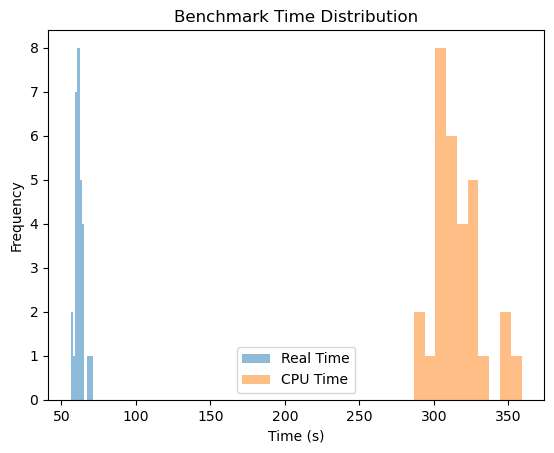

In [80]:
import matplotlib.pyplot as plt

plt.hist(real_times, bins=10, alpha=0.5, label='Real Time')
plt.hist(cpu_times, bins=10, alpha=0.5, label='CPU Time')
plt.legend()
plt.title('Benchmark Time Distribution')
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.show()

Real Time (in blue) has a much smaller range and lower values, concentrated around 50-100 seconds.
CPU Time (in orange) is significantly higher, concentrated around 300-350 seconds.

In [66]:
# Shutdown Ray when done
ray.shutdown()